# Summary

&emsp; This notebook contains code that compares performance of different strategies for cross-subject callibration robustness. The code blocks below load in results data for a small group of held-out test subjects and compares across robustness strategies. Overall, I find that the best strategy for cross-subject robustness is to find a linear transformation of each subject's data before feeding into a simple neural network that has been trained on other subjects' data.

The following notebooks in this repo contain useful data and pre-processing details:
- demo_notebooks/data_exploration_and_quality_check_demo.ipynb
- demo_notebooks/single_subject_demo.ipynb

The following colab_notebooks
contain the code used to assess model performance and write the results to hdf5 files.
- colab_notebooks/simple_NN/within_subject_NN.ipynb
- colab_notebooks/simple_NN/across_subject_NN.ipynb
- colab_notebooks/simple_NN/across_subject_NN_joint_training.ipynb
- colab_notebooks/simple_NN/across_subject_NN_transform_module.ipynb


In [3]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from EMG_gestures.utils import *

# Loading Results
## Test subjects
&emsp; The various strategies for cross-subject callibration robustness explored here required the setting of various hyperparameters such as netwrok architercture or unit activation functions. In order to be able to obtain an unbiased estimate of classification performance, data from a group of 6 randomly-chosen subjects was held-out and not used in the cross-validation process used to set those hyper-parameters. Only results from those held-out subjects is reported and visualized here.

In [1]:
#randomly-selected subjects to use as hold-out test data 
test_subjects = [10, 12, 20, 14, 23, 34]

## Within-subject baseline

&emsp; I first load in baseline data. This baseline results reflect gesture classification performance when using training and testing data from the same subject.

In [4]:
# Load within-subject data for held-out subjects

within_results_df = [] 

results_folder = '../results_data/single_subject_training/simple_NN'
for src_subject_id in test_subjects:
    results_fn = 'subject_%02d_within_subject_results.h5'%(src_subject_id)
    subject_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    subject_df['Train_Subject'] = subject_df['Subject']
    subject_df['Test_Subject'] = subject_df['Subject']
    subject_df = subject_df.drop(columns = ['Subject'])
    within_results_df.append(subject_df)

within_results_df = pd.concat(within_results_df,axis = 0)

# Average over multiple train/test splits of the data
within_results_df = within_results_df.groupby(['Shuffled','Type','Train_Subject','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep','Epochs','Batch_Size','Train_Loss','Val_Loss'])

# Output summary
display(HTML(within_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Train_Subject','Test_Subject']).to_html()))

## Naive cross-subject baseline
&emsp; Another useful baseline is classification performance when a model trained for one subject is tested on another subject without any further modifications (i.e., naive test). 

In [6]:
# Load naive generalization test data for held-out subjects
results_folder = '../results_data/single_subject_training/simple_NN'
naive_results_df = [] 
for src_subject_id in test_subjects:
    results_fn = 'subject_%02d_across_subject_results.h5'%(src_subject_id)
    subject_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    #select data relevant for 
    subject_df = subject_df.loc[subject_df.Test_Subject.isin(test_subjects)]
    naive_results_df.append(subject_df)

naive_results_df = pd.concat(naive_results_df,axis = 0)

# Average over train subjects
naive_results_df = naive_results_df.groupby(['Shuffled','Type','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Train_Subject','Rep','Epochs','Batch_Size','Train_Loss','Val_Loss'])

# Output summary
display(HTML(naive_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Test_Subject']).to_html()))


## Cross-subject robustness strategies

&emsp; Below I load-in performance results for held-out test subjects using two-different strategies for cross-subject robustness.

### Joint training

&emsp; One strategy to produce cross-subject robustness in the neural networks' weights is to pool data across all subjects not included in the held-out set and train the network with this joint data set. This is similar to the idea of producing invariance to image transformations in a convolutional neural netowrk by augmenting the image data set with a variety of image transformations (e.g., randomly cropping, rotating, or scaling images). Modifying the daa in specific ways is possible if one knows the process the generates variation in the data (e.g., objects moving through the world). In the case here, there's little understanding of the factors that lead to variation of EMG data features across subjects other than the very simple transformation that occurs when EMG electrodes are in different positions. For this reason, it makes most sense here to leverage the large number of subjects' data available and simply pool the data which implicitly contains information about the various ways in which EMG data varies across subjects. One short-coming of this approach is that classification performance will drop when presented with variations in the data not present in the training set.

In [7]:
# Load joint training test results
results_folder = '../results_data/xsubject_joint_data/simple_NN'
results_fn = 'nn_joint_testing_results.h5'
joint_results_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
joint_results_df['Type'] = 'Test'
joint_results_df = joint_results_df.groupby(['Shuffled','Type','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Rep'])
# Output summary
display(HTML(joint_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Test_Subject']).to_html()))


,,f1_score,accuracy_score
Shuffled,Type,,
False,Test,0.843134,0.857605
True,Test,0.173404,0.180369


In [ ]:
### Transform module

In [2]:
#comparing: within-subject naive, joint-training, transform module

#held out subjects, Kfold CV used to optimize hyperparams + archs
#naive: train on all others - report on test
#joint-training: train on all others, test on held-out
#transform module: train feature extractor on all others, test on held-out (half of data used for transform module)

#DANN - train on all others, use DANN to adapt



,,f1_score,accuracy_score
Shuffled,Type,,
False,Test,0.843134,0.857605
True,Test,0.173404,0.180369


In [7]:
# Load transform module test results
results_folder = '../results_data/xsubject_transform_module/simple_NN'
results_fn = 'train_model_transform_module_all_testing_data_results.h5'
tm_results_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
tm_results_df['Test_Subject'] = tm_results_df['Subject']
tm_results_df = tm_results_df.drop(columns = ['Subject'])
tm_results_df = tm_results_df.groupby(['Shuffled','Type','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Rep','Fold','Epochs','Batch_Size','Train_Loss','Val_Loss'])
# Output summary
display(HTML(tm_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Test_Subject']).to_html()))


In [8]:
#combine multiple dataframes

# keep test scores only
within_results_df = within_results_df.loc[within_results_df.Type=='Test']
naive_results_df = naive_results_df.loc[naive_results_df.Type=='Test']
joint_results_df = joint_results_df.loc[joint_results_df.Type=='Test']
tm_results_df = tm_results_df.loc[tm_results_df.Type=='Test']
#drop test subject column
within_results_df = within_results_df.drop(columns = ['Train_Subject'])
# label
within_results_df['Test_Type'] = 'Within_Subject'
naive_results_df['Test_Type'] = 'Naive_xSubject'
joint_results_df['Test_Type'] = 'Joint_Training'
tm_results_df['Test_Type'] = 'Transform_Module'
#combine
all_results_df = pd.concat([within_results_df, naive_results_df,\
                            joint_results_df, tm_results_df],axis = 0)


In [9]:
score2use = 'f1_score'
exp_conditions = ['Within_Subject', 'Naive_xSubject', 'Joint_Training', 'Transform_Module']

shuffle_df = all_results_df.loc[all_results_df.Shuffled == True]
true_df = all_results_df.loc[all_results_df.Shuffled == False]

# Get confidence interval for shuffled data results
null_ci = np.zeros((len(exp_conditions),2))

for j,t in enumerate(exp_conditions):
    null_df = shuffle_df.loc[shuffle_df.Test_Type == t]
    null_ci[j,:] = sns.utils.ci(sns.algorithms.bootstrap(null_df[score2use].values))


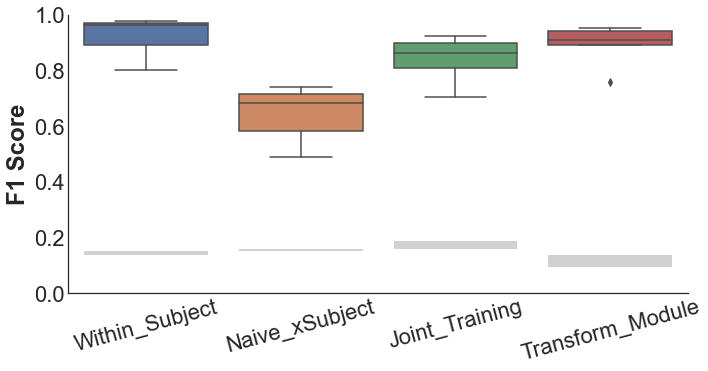

In [10]:

#make plot
g = sns.catplot(data = true_df, x= 'Test_Type', y = score2use,\
            order = exp_conditions, kind = 'box', aspect = 2)

# #Label axes and subpots, mark chance confidence interval
for i,ax in enumerate(g.axes[0]):
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    ax.set_xticklabels(exp_conditions,horizontalalignment = 'center', rotation =15)
    ax.set_ylabel('F1 Score')
    for j,t in enumerate(exp_conditions):
        ax.add_patch(patches.Rectangle(((1*j)-.4, null_ci[j,0]), .8, (null_ci[j,1]-null_ci[j,0]),\
                                             linewidth=0, fill=True, color='k', alpha=0.2))

sns.despine(fig=g.fig, bottom = False)

In [11]:


# Run ANOVA
model = ols('f1_score ~ C(Test_Type)', true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Test_Type),0.284710,3.0,13.919031,0.000039
Residual,0.136365,20.0,NaN,NaN


In [12]:
groups =  true_df['Test_Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(true_df['f1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
  Joint_Training   Naive_xSubject  -0.1978 0.0026 -0.3312 -0.0643   True
  Joint_Training Transform_Module   0.0526 0.6742 -0.0808  0.1861  False
  Joint_Training   Within_Subject   0.0812 0.3485 -0.0522  0.2146  False
  Naive_xSubject Transform_Module   0.2504  0.001   0.117  0.3838   True
  Naive_xSubject   Within_Subject    0.279  0.001  0.1455  0.4124   True
Transform_Module   Within_Subject   0.0286    0.9 -0.1049   0.162  False
------------------------------------------------------------------------


**Conclusion** A one-way ANOVA found a signigicant effect of training type (p<.0001). Post-hoc Tukey tests showed that the within-subject, joint-training, and tranform module test scores were significantly different from the naive cross-subject generalization approach (p<.01 for all). In contrast, there was no siginificant difference among the test scores for between the within-subject, joint-training, and tranform module test scores. This indicates that both the joint training and transfer module approaches produce inter-subject robustness for upper-limb gesture classification from EMG data.